In [1]:
import pandas as pd
import jsonlines
from tqdm import tqdm
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

Using TensorFlow backend.


In [2]:
#Paths
train_db_path='WikiSQL/data/train.db'
train_data_json_path='WikiSQL/data/train.jsonl'
train_table_json_path='WikiSQL/data/train.tables.jsonl'


dev_db_path='WikiSQL/data/dev.db'
dev_data_json_path='WikiSQL/data/dev.jsonl'
dev_table_json_path='WikiSQL/data/dev.tables.jsonl'

test_db_path='WikiSQL/data/test.db'
test_data_json_path='WikiSQL/data/test.jsonl'
test_table_json_path='WikiSQL/data/test.tables.jsonl'

In [3]:
agg_ops = ['', 'MAX', 'MIN', 'COUNT', 'SUM', 'AVG']

In [4]:
def get_col_tokens(table_json_path):
    tokens=[]
    with jsonlines.open(table_json_path) as reader:
        for obj in tqdm(reader):
            for header in obj['header']:
                tokens.append(header)
    return tokens

In [5]:
def get_question_tokens(data_json_path):
    tokens=[]
    with jsonlines.open(data_json_path) as reader:
        for obj in tqdm(reader):
            tokens.append(obj['question'])
    return tokens

In [6]:
texts=[]
texts.extend(get_col_tokens(train_table_json_path))
texts.extend(get_col_tokens(dev_table_json_path))
texts.extend(get_col_tokens(test_table_json_path))

18585it [00:00, 38496.37it/s]
2716it [00:00, 31755.01it/s]
5230it [00:00, 34730.95it/s]


In [7]:
texts.extend(get_question_tokens(train_data_json_path))
texts.extend(get_question_tokens(dev_data_json_path))
texts.extend(get_question_tokens(test_data_json_path))

56355it [00:00, 158390.86it/s]
8421it [00:00, 107006.37it/s]
15878it [00:00, 152213.38it/s]


In [8]:
tokenizer=Tokenizer(char_level=True,lower=True)
tokenizer.fit_on_texts(texts)

In [9]:
max_token_index=len(tokenizer.index_word.keys())+1
max_token_index

1246

In [10]:
def text2seq(text):
    return np.ravel([tokenizer.texts_to_sequences([text])])

In [11]:
max_len=0
for text in texts:
    if len(text2seq(text))>max_len:
        max_len=len(text2seq(text))
max_len

419

In [12]:
def text2seq(text):
    return np.ravel(pad_sequences(tokenizer.texts_to_sequences([text]),maxlen=max_len,padding='post'))

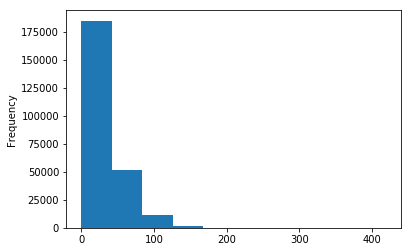

In [13]:
df = pd.Series(texts)
df.str.len().plot(kind='hist')
plt.show()

In [14]:
del texts

In [15]:
#make a dict to keep track of all the columns of all the tables
def get_table(table_json_path):
    tables={}
    with jsonlines.open(table_json_path) as reader:
        for obj in tqdm(reader):
            tables[obj['id']]={'headers':[],'types':[]}
            tables[obj['id']]['headers']=obj['header']
            tables[obj['id']]['types']=obj['types']
    return tables

In [16]:
train_tables=get_table(train_table_json_path)
dev_tables=get_table(dev_table_json_path)
test_tables=get_table(test_table_json_path)

18585it [00:00, 33738.22it/s]
2716it [00:00, 34672.43it/s]
5230it [00:00, 34958.27it/s]


In [17]:
def get_true_select_col(dict_obj,tables):
    temp=tables[dict_obj['table_id']]['headers']
    true_selected_column = temp[dict_obj['sql']['sel']]
    return true_selected_column

In [18]:
def get_dataset(data_json_path,table):
    #read the jsonl file
    Q=[]
    C=[]
    y=[]
    global tokenizer
    with jsonlines.open(data_json_path) as reader:
        for obj in tqdm(reader):
            true_column=get_true_select_col(obj,table)
            question=obj['question']
            agg_func=agg_ops[obj['sql']['agg']]
    
            #tokenized representation
            question=text2seq(question)
            true_column=text2seq(true_column)
    
            
            Q.append(question)
            C.append(true_column)
            y.append(agg_func)
            
    return Q,C,y

In [54]:
Q_train,C_train,y_train=get_dataset(train_data_json_path,train_tables)

56355it [00:04, 12504.24it/s]


In [55]:
Q_dev,C_dev,y_dev=get_dataset(dev_data_json_path,dev_tables)

8421it [00:00, 11563.32it/s]


In [56]:
neg=0
for i in range(len(y_train)):
    if y_train[i]=='':
        neg+=1 
print(neg)

40606


In [57]:
idx=[]
for i in range(len(y_train)):
    if y_train[i]=='':
        #coin toss with 50% prob.
        if np.random.randint(2):
            idx.append(i)
idx.sort(reverse=True)
for i in idx:
    Q_train.pop(i)
    C_train.pop(i)
    y_train.pop(i)

In [58]:
neg=0
for i in range(len(y_train)):
    if y_train[i]=='':
        neg+=1 
print(neg)

20264


In [49]:
from sklearn.utils import compute_class_weight
class_weight=compute_class_weight('balanced', np.unique(y_train), y_train)

In [50]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_train=lb.fit_transform(y_train)
y_dev=lb.transform(y_dev)

In [51]:
pd.DataFrame(y_train).cumsum().iloc[-1]

0    20239
1     2201
2     5114
3     3161
4     3231
5     2042
Name: 35987, dtype: int64

In [52]:
pd.DataFrame(y_dev).cumsum().iloc[-1]

0    6017
1     329
2     779
3     507
4     468
5     321
Name: 8420, dtype: int64

In [23]:
from joblib import dump, load
dump(lb,'lb_agg.joblib')

['lb_agg.joblib']

In [120]:
#dimension
d=64
from keras.models import Model
from keras.layers import Input, GRU, Dense ,Flatten , Concatenate,Bidirectional
from keras.layers.embeddings import Embedding
from keras.constraints import max_norm
from keras import regularizers

In [121]:
# Define an input sequence and process it.
question_input = Input(shape=(max_len,),name='Q_input')
column_input = Input(shape=(max_len,),name='C_input')

embedding= Embedding(max_token_index, d, input_length=max_len,name='embedding')
# embedding_C= Embedding(max_token_index, d, input_length=max_len,name='embedding_C')
#                      embeddings_constraint=max_norm(2.),
#                      embeddings_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))

Q_embedding= embedding(question_input)
C_embedding= embedding(column_input)



encoder_question = Bidirectional(GRU(d, return_state=True))
_ , Q_state_h1, Q_state_h2 = encoder_question(Q_embedding)

encoder_column = Bidirectional(GRU(d, return_state=True))
_ , C_state_h1, C_state_h2 = encoder_column(C_embedding)


con=Concatenate()([Q_state_h1,Q_state_h2,C_state_h1,C_state_h2])


final=Dense(6,activation='softmax')(con)

model = Model([question_input, column_input], final)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Q_input (InputLayer)            (None, 419)          0                                            
__________________________________________________________________________________________________
C_input (InputLayer)            (None, 419)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 419, 64)      79744       Q_input[0][0]                    
                                                                 C_input[0][0]                    
__________________________________________________________________________________________________
bidirectional_11 (Bidirectional [(None, 128), (None, 49536       embedding[0][0]                  
__________

In [122]:
from keras import backend as K

def first_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 0), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc


def second_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 1), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc



def third_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 2), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc


def fourth_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 3), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc


def fifth_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 4), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc


def sixth_class_accuracy(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)
    accuracy_mask = K.cast(K.equal(class_id_preds, 5), 'int32')
    class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
    class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
    return class_acc

In [123]:
from keras import optimizers

opt = optimizers.Adam()

In [124]:
# Run training
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy',
                                                                     first_class_accuracy,
                                                                     second_class_accuracy,
                                                                     third_class_accuracy,
                                                                     fourth_class_accuracy,
                                                                     fifth_class_accuracy,
                                                                     sixth_class_accuracy])

In [125]:
batch_size = 128  # Batch size for training.
epochs = 100  # Number of epochs to train for.

In [126]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='select_agg_best_model.h5', monitor='val_loss', save_best_only=True)]

In [128]:
history=model.fit([Q_train,C_train], y_train,batch_size=batch_size, epochs=epochs, verbose=1,
                  class_weight=class_weight,
                callbacks=callbacks, validation_data=([Q_dev,C_dev],y_dev))

Train on 56355 samples, validate on 8421 samples
Epoch 1/100
56355/56355 [==============================] - 697s 12ms/step - loss: 0.8056 - acc: 0.7586 - first_class_accuracy: 0.7970 - second_class_accuracy: 0.2454 - third_class_accuracy: 0.4473 - fourth_class_accuracy: 0.2981 - fifth_class_accuracy: 0.1389 - sixth_class_accuracy: 0.0318 - val_loss: 0.6328 - val_acc: 0.8098 - val_first_class_accuracy: 0.8992 - val_second_class_accuracy: 0.5554 - val_third_class_accuracy: 0.4957 - val_fourth_class_accuracy: 0.6153 - val_fifth_class_accuracy: 0.3509 - val_sixth_class_accuracy: 0.0000e+00
Epoch 2/100
56355/56355 [==============================] - 691s 12ms/step - loss: 0.5443 - acc: 0.8366 - first_class_accuracy: 0.8911 - second_class_accuracy: 0.8217 - third_class_accuracy: 0.5747 - fourth_class_accuracy: 0.8010 - fifth_class_accuracy: 0.6037 - sixth_class_accuracy: 0.1412 - val_loss: 0.4832 - val_acc: 0.8530 - val_first_class_accuracy: 0.8858 - val_second_class_accuracy: 0.6379 - val_th

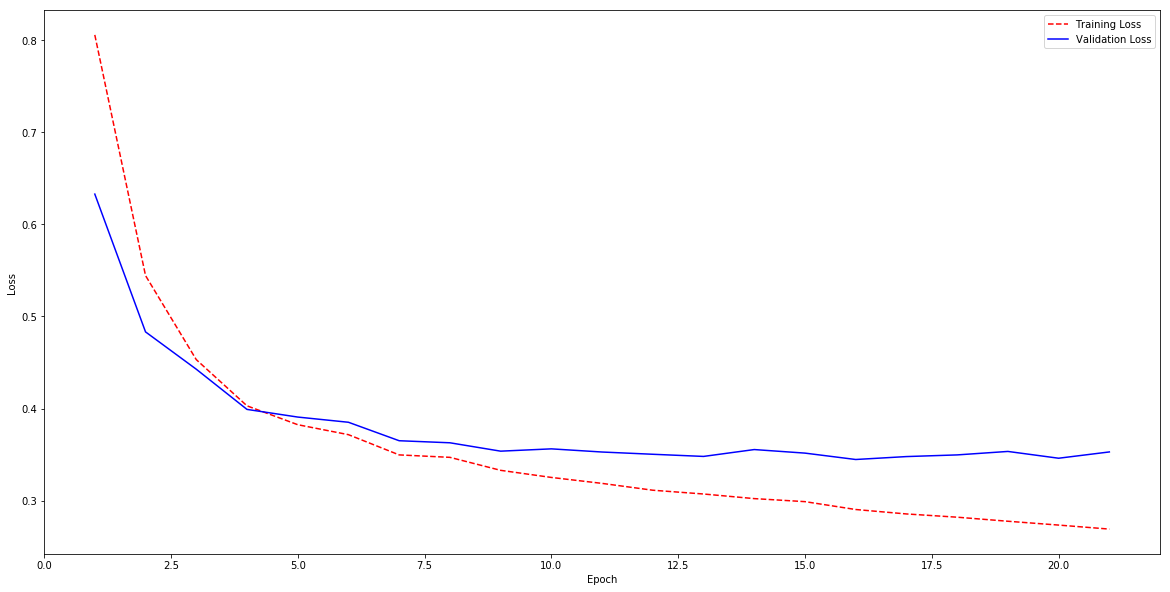

In [129]:

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

plt.figure(figsize=(20,10))
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

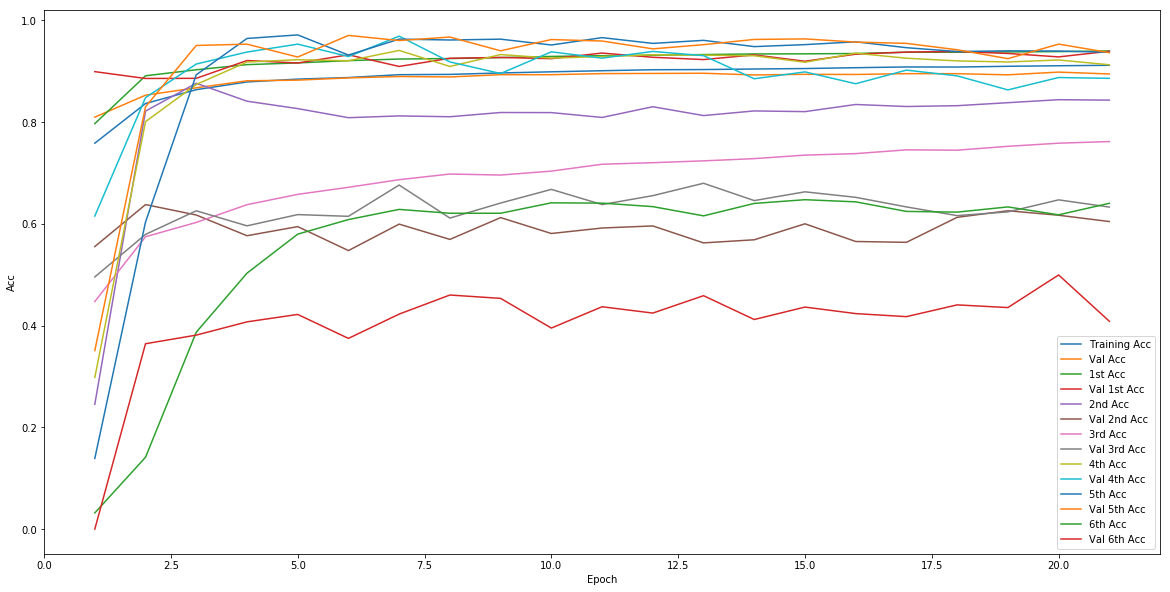

In [130]:

# Get training and test loss histories
training_acc = history.history['acc']
val_acc = history.history['val_acc']

training_one_acc = history.history['first_class_accuracy']
val_one_acc = history.history['val_first_class_accuracy']

training_second_acc = history.history['second_class_accuracy']
val_second_acc = history.history['val_second_class_accuracy']

training_third_acc = history.history['third_class_accuracy']
val_third_acc = history.history['val_third_class_accuracy']

training_fourth_acc = history.history['fourth_class_accuracy']
val_fourth_acc = history.history['val_fourth_class_accuracy']

training_fifth_acc = history.history['fifth_class_accuracy']
val_fifth_acc = history.history['val_fifth_class_accuracy']

training_sixth_acc = history.history['sixth_class_accuracy']
val_sixth_acc = history.history['val_sixth_class_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

plt.figure(figsize=(20,10))
# Visualize loss history
plt.plot(epoch_count, training_acc)
plt.plot(epoch_count, val_acc)

plt.plot(epoch_count, training_one_acc)
plt.plot(epoch_count, val_one_acc)

plt.plot(epoch_count, training_second_acc)
plt.plot(epoch_count, val_second_acc)

plt.plot(epoch_count, training_third_acc)
plt.plot(epoch_count, val_third_acc)


plt.plot(epoch_count, training_fourth_acc)
plt.plot(epoch_count, val_fourth_acc)

plt.plot(epoch_count, training_fifth_acc)
plt.plot(epoch_count, val_fifth_acc)

plt.plot(epoch_count, training_sixth_acc)
plt.plot(epoch_count, val_sixth_acc)

plt.legend(['Training Acc', 'Val Acc',
           '1st Acc','Val 1st Acc',
           '2nd Acc','Val 2nd Acc',
           '3rd Acc','Val 3rd Acc',
           '4th Acc','Val 4th Acc',
           '5th Acc','Val 5th Acc',
           '6th Acc','Val 6th Acc',])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show();

In [113]:
model.load_weights('select_agg_best_model.h5')

In [114]:
Q_test,C_test,y_test=get_dataset(test_data_json_path,test_tables)

15878it [00:02, 7897.84it/s]


In [115]:
y_test=lb.transform(y_test)

In [119]:
#new
model.evaluate([Q_test,C_test],y_test,verbose=1)

15878/15878 [==============================] - 87s 5ms/step


[0.3560865578246456,
 0.8921148759364661,
 0.9208884739819794,
 0.4224881387244405,
 0.5567816293096555,
 0.677767980854012,
 0.6939724926373122,
 0.28265524625267674]

In [118]:
model.evaluate([Q_train,C_train],y_train,verbose=1)

56355/56355 [==============================] - 313s 6ms/step


[0.27695814714201933,
 0.9107798775618845,
 0.9343463480931381,
 0.44742802500587947,
 0.6076727885724426,
 0.6588836922400932,
 0.6963218711315597,
 0.2926495726495727]

In [117]:
model.evaluate([Q_dev,C_dev],y_dev,verbose=1)

8421/8421 [==============================] - 46s 6ms/step


[0.35370619327189123,
 0.8914618216363852,
 0.9261934578059541,
 0.42970125706142803,
 0.5990057495579406,
 0.7125553463280575,
 0.6680441752760955,
 0.2736650437398568]

In [111]:
model.metrics_names

['loss',
 'acc',
 'first_class_accuracy',
 'second_class_accuracy',
 'third_class_accuracy',
 'fourth_class_accuracy',
 'fifth_class_accuracy',
 'sixth_class_accuracy']